In [1]:
# Cell 1: Install & imports

!pip install torch torchvision timm scikit-image --quiet

import os, glob, math, csv, random, time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.cuda.amp import autocast, GradScaler

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed_all(42)


Device: cuda


In [3]:
# Cell 2: Dataset + Dataloaders (updated for big dataset, safe settings)

from google.colab import drive
drive.mount('/content/drive')

import glob, random
from PIL import Image
from torchvision import transforms

# ======= SET YOUR FOLDERS HERE =======
train_dir = "/content/drive/MyDrive/Moon Kaggle Images/Training"   # change to your 8500 image folder
test_dir  = "/content/drive/MyDrive/Moon Kaggle Images/Testing"    # change to your test/val folder
# =====================================

hr_size = 256      # high-resolution patch size (you can reduce to 192 if still OOM)
scale   = 4        # SR scale factor
lr_size = hr_size // scale

# SAFER VALUES for big dataset
batch_size  = 2
num_workers = 1
pin_mem     = True if device.type == "cuda" else False

def random_flip_rotate(img):
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

class SRDatasetCorrect(Dataset):
    def __init__(self, folder, hr_size=256, scale=4, augment=False):
        exts = ("*.png","*.jpg","*.jpeg")
        files = []
        for e in exts:
            files += glob.glob(os.path.join(folder, e))
        files = sorted(files)
        if len(files) == 0:
            raise ValueError(f"No images found in {folder}")
        self.files = files
        self.hr_size = hr_size
        self.scale = scale
        self.lr_size = hr_size // scale
        self.augment = augment
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        # make HR: resize to exact HR size
        hr = img.resize((self.hr_size, self.hr_size), Image.BICUBIC)
        if self.augment:
            hr = random_flip_rotate(hr)
        # LR by downscaling from HR
        lr = hr.resize((self.lr_size, self.lr_size), Image.BICUBIC)
        return self.to_tensor(lr), self.to_tensor(hr)

# Create datasets
train_ds = SRDatasetCorrect(train_dir, hr_size=hr_size, scale=scale, augment=True)
test_ds  = SRDatasetCorrect(test_dir,  hr_size=hr_size, scale=scale, augment=False)

# Create loaders (safe)
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_mem,
    persistent_workers=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=pin_mem
)

print("Train images:", len(train_ds), "Test images:", len(test_ds))
print("HR size:", hr_size, "LR size:", lr_size, "Scale:", scale)
print("Batch size:", batch_size, "Workers:", num_workers)


Mounted at /content/drive
Train images: 8856 Test images: 4
HR size: 256 LR size: 64 Scale: 4
Batch size: 2 Workers: 1


In [4]:
# Cell 3: Discriminator (robust, scalar output [B,1])

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        def conv(in_c, out_c, stride=1, bn=True):
            layers = [nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        c = base_channels
        self.block1 = conv(in_channels, c, stride=1, bn=False)
        self.block2 = conv(c, c, stride=2)
        self.block3 = conv(c, c*2, stride=1)
        self.block4 = conv(c*2, c*2, stride=2)
        self.block5 = conv(c*2, c*4, stride=1)
        self.block6 = conv(c*4, c*4, stride=2)
        self.block7 = conv(c*4, c*8, stride=1)
        self.block8 = conv(c*8, c*8, stride=2)

        # Global pooling -> small MLP -> 1 logit
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.gap(x)
        x = self.fc(x)
        return x   # [B,1] logits


In [5]:
# Cell 4: VGG feature extractor and loss functions

vgg = models.vgg19(pretrained=True).features[:36].to(device).eval()
for p in vgg.parameters():
    p.requires_grad = False

mse_loss = nn.MSELoss()
l1_loss  = nn.L1Loss()
bce_loss = nn.BCEWithLogitsLoss()

def vgg_loss(x, y):
    # x, y in [-1,1] -> convert to [0,1] then normalize for VGG
    def to_vgg(inp):
        inp = (inp + 1.0) / 2.0
        mean = torch.tensor([0.485,0.456,0.406], device=inp.device).view(1,3,1,1)
        std  = torch.tensor([0.229,0.224,0.225], device=inp.device).view(1,3,1,1)
        return (inp - mean) / std

    fx = vgg(to_vgg(x))
    fy = vgg(to_vgg(y))
    return l1_loss(fx, fy)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 244MB/s]


In [6]:
# Cell 5: Generator, optimizers, schedulers, loss weights

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, scale_factor=4, in_channels=3, num_res_blocks=16, base_channels=64):
        super(Generator, self).__init__()
        self.initial_block = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(base_channels) for _ in range(num_res_blocks)]
        )

        self.mid_conv = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels)
        )

        upsample_blocks = []
        for _ in range(int(math.log2(scale_factor))):
            upsample_blocks += [
                nn.Conv2d(base_channels, base_channels * 4, kernel_size=3, stride=1, padding=1),
                nn.PixelShuffle(2),
                nn.PReLU()
            ]
        self.upsampling = nn.Sequential(*upsample_blocks)

        self.final_conv = nn.Conv2d(base_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial_features = self.initial_block(x)
        res_features = self.res_blocks(initial_features)
        mid_features = self.mid_conv(res_features) + initial_features
        upsampled_features = self.upsampling(mid_features)
        out = self.final_conv(upsampled_features)
        return torch.tanh(out)   # [-1,1]

# Instantiate models
generator     = Generator(scale_factor=scale, in_channels=3, num_res_blocks=16, base_channels=64).to(device)
discriminator = Discriminator(in_channels=3, base_channels=64).to(device)

# Optimizers & schedulers
lr_G = 1e-4
lr_D = 1e-4

optimizer_G = optim.AdamW(generator.parameters(), lr=lr_G, betas=(0.9,0.999))
optimizer_D = optim.AdamW(discriminator.parameters(), lr=lr_D, betas=(0.9,0.999))

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.5)

# AMP scalers
scaler_G = GradScaler()
scaler_D = GradScaler()

# Loss weights (content + perceptual + small adversarial)
w_l1  = 1.0
w_vgg = 0.006
w_adv = 1e-3

print("Loss weights -> L1:", w_l1, "| VGG:", w_vgg, "| ADV:", w_adv)


Loss weights -> L1: 1.0 | VGG: 0.006 | ADV: 0.001


/tmp/ipython-input-715929684.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler()
/tmp/ipython-input-715929684.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler()


In [8]:
# Cell 6: SRGAN training loop (train ALL images, faster view, OOM-safe)

from tqdm.auto import tqdm

epochs   = 10
ckpt_dir = "/content/srgan_checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
best_psnr = -1.0

# validate only on some batches to save time (training still uses ALL)
max_val_batches = 50   # increase if you want more accurate val

def clear_oom():
    if device.type == "cuda":
        torch.cuda.empty_cache()

for epoch in range(1, epochs+1):
    generator.train()
    discriminator.train()
    running_G, running_D, steps = 0.0, 0.0, 0

    # nice progress bar so it doesn’t “look stuck”
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)

    # ---------- TRAIN (uses ALL batches in train_loader) ----------
    for lr_imgs, hr_imgs in train_bar:
        try:
            lr_imgs = lr_imgs.to(device) * 2.0 - 1.0   # [0,1] -> [-1,1]
            hr_imgs = hr_imgs.to(device) * 2.0 - 1.0

            # --------- Train Discriminator ---------
            optimizer_D.zero_grad(set_to_none=True)
            with autocast():
                fake_imgs   = generator(lr_imgs).detach()
                real_logits = discriminator(hr_imgs)
                fake_logits = discriminator(fake_imgs)

                loss_real = bce_loss(real_logits, torch.ones_like(real_logits))
                loss_fake = bce_loss(fake_logits, torch.zeros_like(fake_logits))
                loss_D    = 0.5 * (loss_real + loss_fake)

            scaler_D.scale(loss_D).backward()
            scaler_D.unscale_(optimizer_D)
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
            scaler_D.step(optimizer_D)
            scaler_D.update()
            running_D += loss_D.item()

            # --------- Train Generator ---------
            optimizer_G.zero_grad(set_to_none=True)
            with autocast():
                gen_imgs    = generator(lr_imgs)
                loss_l1     = l1_loss(gen_imgs, hr_imgs)
                loss_vgg    = vgg_loss(gen_imgs, hr_imgs)
                pred_logits = discriminator(gen_imgs)
                adv_targets = torch.ones_like(pred_logits)
                loss_adv    = bce_loss(pred_logits, adv_targets)

                loss_G = w_l1 * loss_l1 + w_vgg * loss_vgg + w_adv * loss_adv

            scaler_G.scale(loss_G).backward()
            scaler_G.unscale_(optimizer_G)
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
            scaler_G.step(optimizer_G)
            scaler_G.update()
            running_G += loss_G.item()
            steps += 1

            # update progress bar text
            if steps % 10 == 0:
                train_bar.set_postfix({
                    "G": f"{loss_G.item():.4f}",
                    "D": f"{loss_D.item():.4f}"
                })

        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print("⚠️ CUDA OOM on this batch, skipping it…")
                clear_oom()
                continue
            else:
                raise e

    # step schedulers once per epoch
    scheduler_G.step()
    scheduler_D.step()

    avg_G = running_G / max(1, steps)
    avg_D = running_D / max(1, steps)

    # ---------- VALIDATION (subset of val for speed) ----------
    generator.eval()
    psnrs, ssims = [], []

    with torch.no_grad():
        for v_idx, (vlr, vhr) in enumerate(test_loader):
            if v_idx >= max_val_batches:   # don’t run full val set (saves time)
                break

            vlr = vlr.to(device) * 2.0 - 1.0
            vhr = vhr.to(device) * 2.0 - 1.0
            out = generator(vlr)

            out_np = ((out.cpu().permute(0,2,3,1).numpy() + 1)/2.0 * 255.0).clip(0,255).astype(np.uint8)
            hr_np  = ((vhr.cpu().permute(0,2,3,1).numpy() + 1)/2.0 * 255.0).clip(0,255).astype(np.uint8)

            for i in range(out_np.shape[0]):
                p = compare_psnr(hr_np[i], out_np[i], data_range=255)
                s = compare_ssim(hr_np[i], out_np[i], data_range=255, channel_axis=2)
                psnrs.append(p)
                ssims.append(s)

    mean_psnr = float(np.mean(psnrs)) if psnrs else float('nan')
    mean_ssim = float(np.mean(ssims)) if ssims else float('nan')

    # save best by PSNR
    if not math.isnan(mean_psnr) and mean_psnr > best_psnr:
        best_psnr = mean_psnr
        torch.save(generator.state_dict(),     os.path.join(ckpt_dir, "best_generator.pth"))
        torch.save(discriminator.state_dict(), os.path.join(ckpt_dir, "best_discriminator.pth"))

    # log to csv
    with open(os.path.join(ckpt_dir,"log.csv"), "a", newline="") as f:
        csv.writer(f).writerow([epoch, avg_G, avg_D, mean_psnr, mean_ssim, best_psnr])

    print(f"Epoch {epoch}/{epochs} | "
          f"G: {avg_G:.5f} | D: {avg_D:.5f} | "
          f"Val PSNR: {mean_psnr:.3f} dB | Val SSIM: {mean_ssim:.4f} | "
          f"Best PSNR: {best_psnr:.3f}")


Epoch 1/10:   0%|          | 0/4428 [00:00<?, ?it/s]

/tmp/ipython-input-1512166106.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-1512166106.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10 | G: 0.04221 | D: 0.42121 | Val PSNR: 25.104 dB | Val SSIM: 0.6408 | Best PSNR: 25.104


Epoch 2/10:   0%|          | 0/4428 [00:00<?, ?it/s]

Epoch 2/10 | G: 0.04054 | D: 0.38243 | Val PSNR: 24.876 dB | Val SSIM: 0.6133 | Best PSNR: 25.104


Epoch 3/10:   0%|          | 0/4428 [00:00<?, ?it/s]

Epoch 3/10 | G: 0.03698 | D: 0.51159 | Val PSNR: 25.166 dB | Val SSIM: 0.6360 | Best PSNR: 25.166


Epoch 4/10:   0%|          | 0/4428 [00:00<?, ?it/s]

Epoch 4/10 | G: 0.03551 | D: 0.48088 | Val PSNR: 25.157 dB | Val SSIM: 0.6381 | Best PSNR: 25.166


Epoch 5/10:   0%|          | 0/4428 [00:00<?, ?it/s]

Epoch 5/10 | G: 0.03418 | D: 0.51130 | Val PSNR: 25.166 dB | Val SSIM: 0.6363 | Best PSNR: 25.166


Epoch 6/10:   0%|          | 0/4428 [00:00<?, ?it/s]

Epoch 6/10 | G: 0.03321 | D: 0.45392 | Val PSNR: 25.431 dB | Val SSIM: 0.6712 | Best PSNR: 25.431


Epoch 7/10:   0%|          | 0/4428 [00:00<?, ?it/s]

Epoch 7/10 | G: 0.03305 | D: 0.43906 | Val PSNR: 25.587 dB | Val SSIM: 0.6703 | Best PSNR: 25.587


Epoch 8/10:   0%|          | 0/4428 [00:00<?, ?it/s]

Epoch 8/10 | G: 0.03282 | D: 0.49011 | Val PSNR: 25.543 dB | Val SSIM: 0.6597 | Best PSNR: 25.587


Epoch 9/10:   0%|          | 0/4428 [00:00<?, ?it/s]

Epoch 9/10 | G: 0.03262 | D: 0.47824 | Val PSNR: 25.399 dB | Val SSIM: 0.6507 | Best PSNR: 25.587


Epoch 10/10:   0%|          | 0/4428 [00:00<?, ?it/s]

Epoch 10/10 | G: 0.03265 | D: 0.49811 | Val PSNR: 25.414 dB | Val SSIM: 0.6584 | Best PSNR: 25.587


In [10]:
# Cell 7: Final evaluation + save SR images

out_dir = "/content/srgan_outputs"
os.makedirs(out_dir, exist_ok=True)

best_gen_path = os.path.join(ckpt_dir, "best_generator.pth")
if os.path.exists(best_gen_path):
    try:
        generator.load_state_dict(torch.load(best_gen_path, map_location=device))
        print("Loaded best generator:", best_gen_path)
    except Exception as e:
        print("Could not load checkpoint:", e)

generator.eval()
psnrs = []
ssims = []

def to_uint8(img_tensor):
    x = img_tensor
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    if x.ndim == 4:
        x = x[0]
    x = np.transpose(x, (1,2,0))
    if x.min() >= -1.1 and x.max() <= 1.1:
        x = (x + 1.0) / 2.0
    x = np.clip(x, 0.0, 1.0)
    x_u8 = (x * 255.0).round().astype(np.uint8)
    return x_u8

with torch.no_grad():
    idx = 0
    for lr, hr in test_loader:
        lr = lr.to(device)
        hr = hr.to(device)

        sr = generator(lr)
        sr_u8 = to_uint8(sr)
        hr_u8 = to_uint8(hr)

        if sr_u8.shape != hr_u8.shape:
            h_min = min(sr_u8.shape[0], hr_u8.shape[0])
            w_min = min(sr_u8.shape[1], hr_u8.shape[1])
            sr_u8 = sr_u8[:h_min, :w_min, ...]
            hr_u8 = hr_u8[:h_min, :w_min, ...]

        save_path = os.path.join(out_dir, f"sr_{idx}.png")
        plt.imsave(save_path, sr_u8)

        try:
            p = compare_psnr(hr_u8, sr_u8, data_range=255)
        except Exception:
            p = compare_psnr(hr_u8[...,0], sr_u8[...,0], data_range=255)
        try:
            s = compare_ssim(hr_u8, sr_u8, data_range=255, channel_axis=2)
        except Exception:
            s = compare_ssim(hr_u8[...,0], sr_u8[...,0], data_range=255)
        psnrs.append(p)
        ssims.append(s)
        idx += 1

final_psnr = float(np.mean(psnrs)) if psnrs else float('nan')
final_ssim = float(np.mean(ssims)) if ssims else float('nan')

print("===== FINAL METRICS =====")
print(f"Final Mean PSNR: {final_psnr:.3f} dB")
print(f"Final Mean SSIM: {final_ssim:.4f}")
print("Saved SR images to:", out_dir)


Loaded best generator: /content/srgan_checkpoints/best_generator.pth
===== FINAL METRICS =====
Final Mean PSNR: 28.240 dB
Final Mean SSIM: 0.7604
Saved SR images to: /content/srgan_outputs


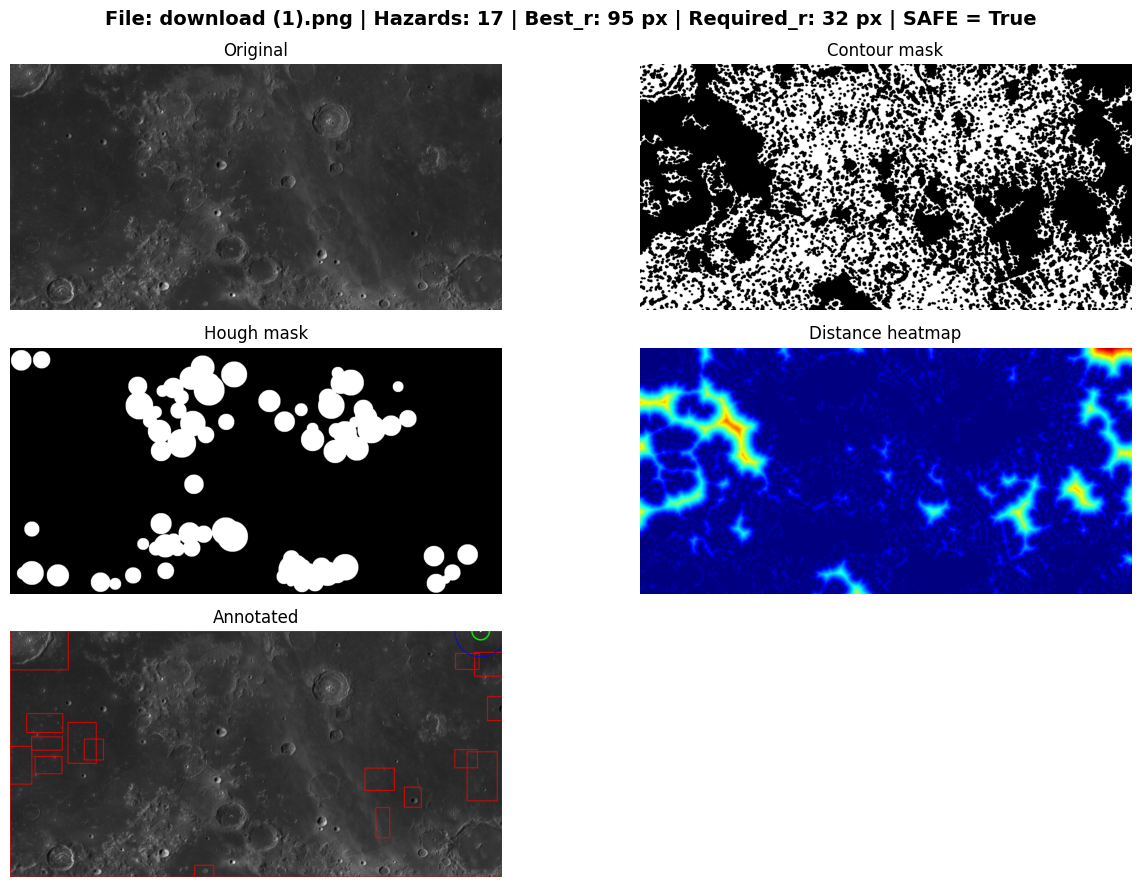

File: download (1).png | Hazards: 17 | Best_r: 95 px | Required_r: 32 px | SAFE = True | saved -> /content/test_hazard_annotated/download (1).png


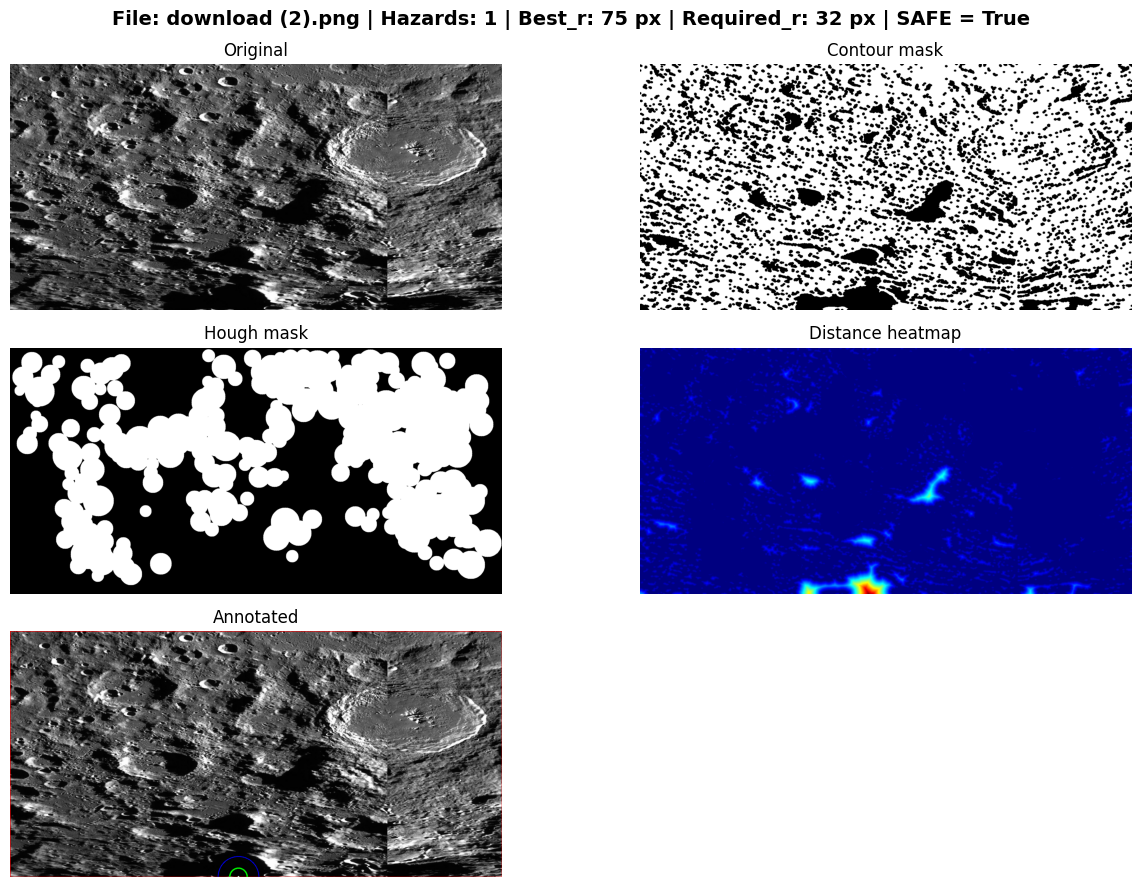

File: download (2).png | Hazards: 1 | Best_r: 75 px | Required_r: 32 px | SAFE = True | saved -> /content/test_hazard_annotated/download (2).png


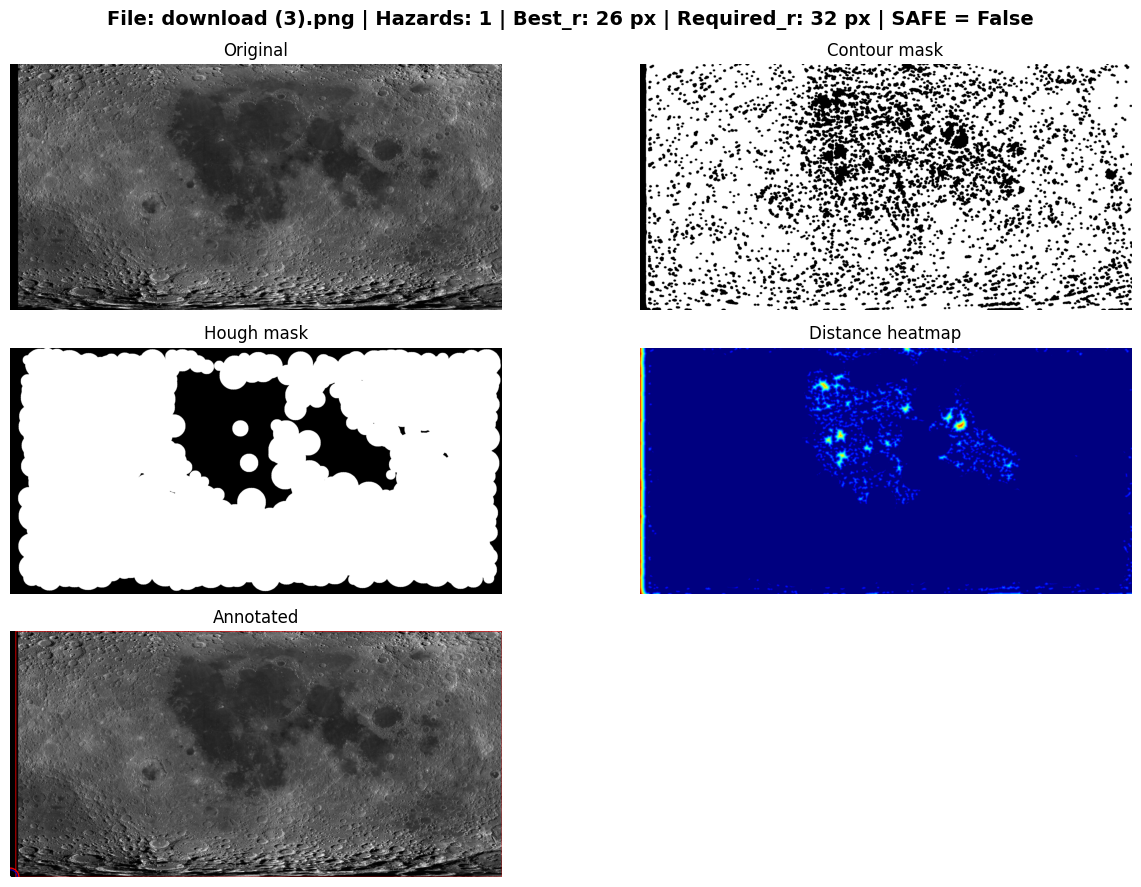

File: download (3).png | Hazards: 1 | Best_r: 26 px | Required_r: 32 px | SAFE = False | saved -> /content/test_hazard_annotated/download (3).png


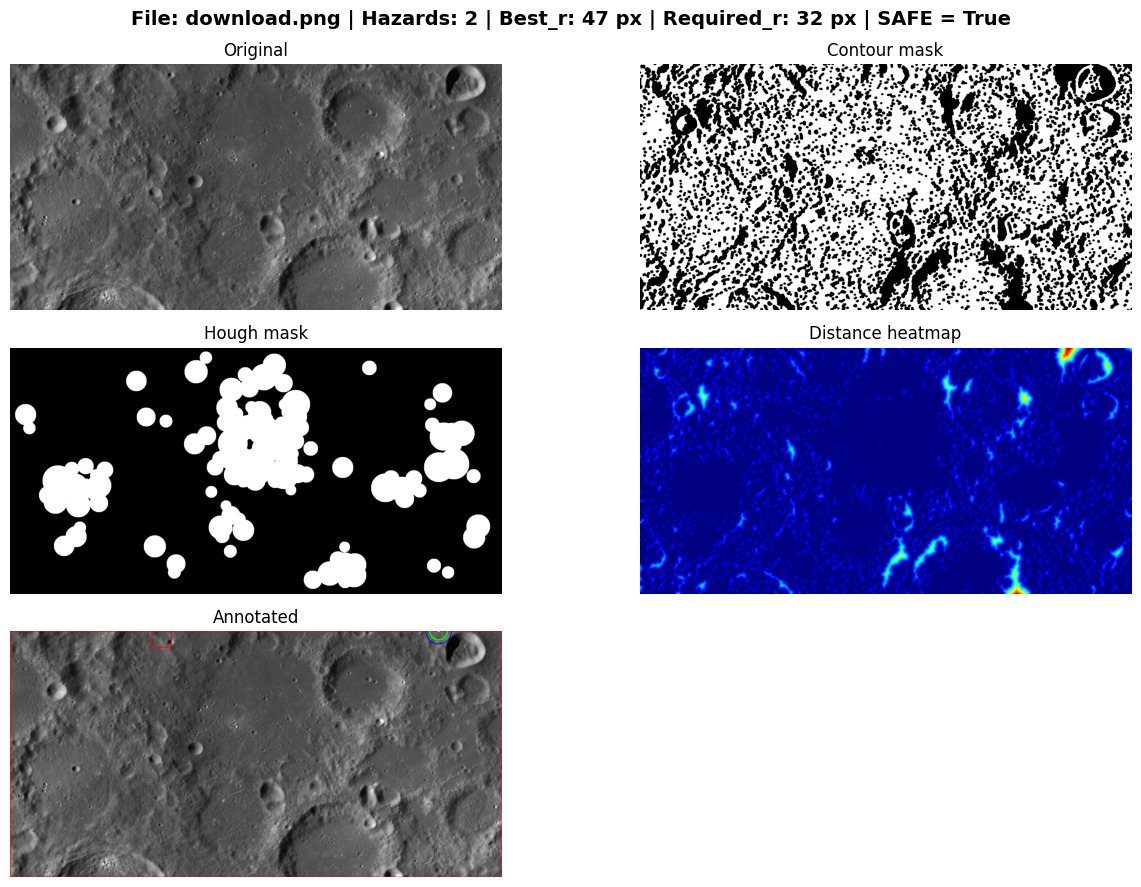

File: download.png | Hazards: 2 | Best_r: 47 px | Required_r: 32 px | SAFE = True | saved -> /content/test_hazard_annotated/download.png

Done — All outputs saved in: /content/test_hazard_annotated


In [9]:
# Cell: Hazard detection + landing circle + hazard counts on TEST IMAGES only

import os, cv2, numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, exposure

# Use the same test_dir that you set in Cell 2
src_dir = test_dir                              # <-- ONLY testing images
out_dir = "/content/test_hazard_annotated"      # output folder
os.makedirs(out_dir, exist_ok=True)

# ---------- TUNE THESE ----------
min_hazard_area   = 800      # minimum area to count as hazard
landing_radius_px = 32       # required safe landing radius in pixels
MAX_SHOW          = 10       # show only first 10 images
# Hough circle params
hough_dp = 1.2
hough_minDist = 30
hough_param1 = 100
hough_param2 = 60
hough_minRadius = 10
hough_maxRadius = 60
hough_overlap_iou_thresh = 0.12
border_ignore = 6
# -------------------------------

def show_grid(images, titles=None, header_text="", figsize=(13,9)):
    plt.figure(figsize=figsize)
    plt.suptitle(header_text, fontsize=14, fontweight='bold')

    n = len(images)
    cols = 2
    rows = (n + cols - 1) // cols

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def detect_and_filter(img_bgr):
    h, w = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_eq = exposure.equalize_adapthist(gray, clip_limit=0.03)
    gray_eq = (gray_eq * 255).astype(np.uint8)
    blur = cv2.GaussianBlur(gray_eq, (5,5), 0)

    th = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 31, 9
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    th_closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    th_bool = th_closed.astype(bool)
    th_clean = morphology.remove_small_objects(th_bool, min_size=min_hazard_area)
    mask_contour = (th_clean.astype('uint8') * 255)

    circles = cv2.HoughCircles(
        blur, cv2.HOUGH_GRADIENT, dp=hough_dp,
        minDist=hough_minDist,
        param1=hough_param1,
        param2=hough_param2,
        minRadius=hough_minRadius,
        maxRadius=hough_maxRadius
    )

    mask_hough = np.zeros((h,w), dtype=np.uint8)
    accepted_hough = []

    if circles is not None:
        circles = np.round(circles[0,:]).astype(int)
        circles = sorted(circles.tolist(), key=lambda x: -x[2])  # largest first

        for (cx, cy, r) in circles:
            if cx < border_ignore or cy < border_ignore or cx > w-border_ignore or cy > h-border_ignore:
                continue
            if r < hough_minRadius or r > hough_maxRadius:
                continue

            circ_mask = np.zeros((h,w), dtype=np.uint8)
            rr = max(1, r-2)
            cv2.circle(circ_mask, (cx,cy), rr, 255, -1)

            inter = np.logical_and(circ_mask>0, mask_contour>0).sum()
            circ_area = circ_mask.sum() / 255.0
            if circ_area == 0:
                continue

            overlap = inter / circ_area
            if overlap >= hough_overlap_iou_thresh:
                accepted_hough.append((cx,cy,r,overlap))
                cv2.circle(mask_hough, (cx,cy), rr, 255, -1)

    combined = cv2.bitwise_or(mask_contour, mask_hough)
    comb_bool = combined.astype(bool)
    comb_clean = morphology.remove_small_objects(comb_bool, min_size=min_hazard_area)
    final_mask = (comb_clean.astype('uint8') * 255)

    return mask_contour, mask_hough, final_mask, accepted_hough

def find_landing(mask, required_radius):
    h, w = mask.shape[:2]
    if np.sum(mask) == 0:
        # no hazards, center is safe
        return h//2, w//2, min(h,w)//3, True

    free = (mask == 0).astype(np.uint8)
    dist = cv2.distanceTransform(free, cv2.DIST_L2, 5)

    ys, xs = np.where(dist >= required_radius)
    if len(ys) > 0:
        best_idx = np.argmax(dist[ys, xs])
        cy, cx = int(ys[best_idx]), int(xs[best_idx])
        return cy, cx, int(dist[cy,cx]), True

    _, maxVal, _, maxLoc = cv2.minMaxLoc(dist)
    cy, cx = maxLoc[1], maxLoc[0]
    best_r = int(maxVal)
    best_r = min(best_r, min(h//2, w//2))
    return cy, cx, best_r, False

shown = 0
for fname in sorted(os.listdir(src_dir)):
    if not fname.lower().endswith((".png",".jpg",".jpeg")):
        continue

    path = os.path.join(src_dir, fname)
    img = cv2.imread(path)
    if img is None:
        continue

    h, w = img.shape[:2]

    mask_contour, mask_hough, mask_final, accepted_hough = detect_and_filter(img)
    cy, cx, best_r, is_safe = find_landing(mask_final, landing_radius_px)

    contours, _ = cv2.findContours(mask_final.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hazard_count = 0
    out = img.copy()

    for c in contours:
        area = cv2.contourArea(c)
        if area < min_hazard_area:
            continue
        hazard_count += 1
        x,y,ww,hh = cv2.boundingRect(c)
        cv2.rectangle(out, (x,y), (x+ww,y+hh), (0,0,255), 2)

    br = max(1, min(best_r, min(h//2, w//2)))
    color_required = (0,255,0) if is_safe else (0,0,255)

    cv2.circle(out, (cx,cy), br, (255,0,0), 2)                # max safe circle
    cv2.circle(out, (cx,cy), landing_radius_px, color_required, 3)  # rover landing area
    cv2.circle(out, (cx,cy), 3, (255,255,255), -1)

    header = (
        f"File: {fname} | Hazards: {hazard_count} | "
        f"Best_r: {best_r} px | Required_r: {landing_radius_px} px | "
        f"SAFE = {is_safe}"
    )

    # distance heatmap just for visualization
    free = (mask_final == 0).astype(np.uint8)
    dist = cv2.distanceTransform(free, cv2.DIST_L2, 5)
    if dist.max() > 0:
        dv = (dist / dist.max() * 255).astype(np.uint8)
    else:
        dv = dist.astype(np.uint8)
    dist_color = cv2.applyColorMap(dv, cv2.COLORMAP_JET)

    save_path = os.path.join(out_dir, fname)
    cv2.imwrite(save_path, out)

    if shown < MAX_SHOW:
        show_grid(
            [
                cv2.cvtColor(img,          cv2.COLOR_BGR2RGB),
                cv2.cvtColor(mask_contour, cv2.COLOR_GRAY2RGB),
                cv2.cvtColor(mask_hough,   cv2.COLOR_GRAY2RGB),
                cv2.cvtColor(dist_color,   cv2.COLOR_BGR2RGB),
                cv2.cvtColor(out,          cv2.COLOR_BGR2RGB)
            ],
            titles=["Original", "Contour mask", "Hough mask", "Distance heatmap", "Annotated"],
            header_text=header
        )
        shown += 1

    print(header, "| saved ->", save_path)

print("\nDone — All outputs saved in:", out_dir)
